In [51]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.stats import zscore, pearsonr

from collections import defaultdict, Counter

import scipy.spatial as sp
import scipy.cluster.hierarchy as hc

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from tqdm.auto import tqdm
tqdm.pandas()

/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/tqdm/_tqdm.py:603: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [26]:
tss1kb_meth = pd.read_hdf("../data/CCLE_RRBS_TSS1kb_20181022.hdf",key="tss1kb_meth")
ccle_genex = pd.read_hdf("../data/CCLE_RNAseq_rsem_genes_tpm_20180929.hdf",key="ccle_genex")

avana = pd.read_hdf("../data/Achilles_gene_effect.hdf",key="avana")
drive = pd.read_hdf("../data/D2_DRIVE_gene_dep_scores.hdf",key="drive")
achilles = pd.read_hdf("../data/D2_Achilles_gene_dep_scores.hdf",key="achilles")

# Methylation and mRNA expression

In [41]:
meth_genes = pd.DataFrame(index=tss1kb_meth.columns)
meth_genes["gene_name"] = meth_genes.index.map(lambda x: x.split("_")[0])

genex_genes = pd.DataFrame(index=ccle_genex.columns)
genex_genes["gene_name"] = genex_genes.index.map(lambda x: "_".join(x.split("_")[:-1]))
genex_genes["ensembl_id_v"] = genex_genes.index.map(lambda x: x.split("_")[-1])
genex_genes["ensembl_id"] = genex_genes["ensembl_id_v"].apply(lambda x: x.split(".")[0])

In [52]:
genex_gene_map = dict(zip(genex_genes["gene_name"], genex_genes.index))

meth_matched = meth_genes.copy()

meth_matched["genex_id"] = meth_matched["gene_name"].apply(lambda x: genex_gene_map.get(x, ""))

meth_matched = meth_matched[meth_matched["genex_id"]!=""]

def meth_genex_correlate(row):
    meth_name = row.name
    genex_name = row["genex_id"]
    
    meth = tss1kb_meth[meth_name].dropna()
    genex = ccle_genex[genex_name].dropna()
    
    meth, genex = meth.align(genex, axis=0, join="inner")
    
    r, pval = pearsonr(meth, genex)
    
    row["corr"] = r
    row["pval"] = pval
    row["n"] = len(meth)
    
    return row

meth_matched = meth_matched.progress_apply(meth_genex_correlate, axis=1)
meth_matched = meth_matched.dropna()

/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


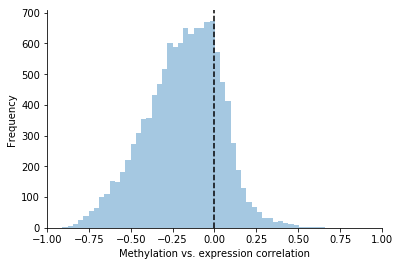

In [65]:
ax = plt.subplot(111)

sns.distplot(meth_matched["corr"],kde=False)
plt.xlabel("Methylation vs. expression correlation")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.ylabel("Frequency")
plt.xlim(-1,1)

plt.axvline(0,linestyle="--",color="black")

# Methylation and dependency

In [24]:
string = pd.read_csv("../data/9606.protein.links.v11.0.txt.gz",sep=" ")
string = string[string["combined_score"]>=800]

string["protein1_ensembl"] = string["protein1"].apply(lambda x: x[5:])
string["protein2_ensembl"] = string["protein2"].apply(lambda x: x[5:])


In [25]:
ensembl_gene_protein = pd.read_csv("../data/ensembl_gene_protein.txt",sep="\t")
ensembl_gene_protein = ensembl_gene_protein.dropna(subset=["Protein stable ID","NCBI gene ID"])
ensembl_gene_protein["NCBI gene ID"] = ensembl_gene_protein["NCBI gene ID"].astype(int).astype(str)

protein_gene_map = dict(zip(ensembl_gene_protein["Protein stable ID"],ensembl_gene_protein["Gene stable ID"]))

string["gene1_ensembl"]  = string["protein1_ensembl"].apply(lambda x: protein_gene_map.get(x,np.nan))
string["gene2_ensembl"]  = string["protein2_ensembl"].apply(lambda x: protein_gene_map.get(x,np.nan))

string = string.dropna()

In [27]:
entrez_ensembl_map = dict(zip(ensembl_gene_protein["NCBI gene ID"],ensembl_gene_protein["Gene stable ID"]))

In [31]:
genes_info = pd.DataFrame(index = ccle_genex.columns)

genes_info["gene_name"] = genes_info.index.map(lambda x: "_".join(x.split("_")[:-1]))
genes_info["ensembl_id_v"] = genes_info.index.map(lambda x: x.split("_")[-1])
genes_info["ensembl_id"] = genes_info["ensembl_id_v"].apply(lambda x: x.split(".")[0])

ensembl_name_map = dict(zip(genes_info["ensembl_id"],genes_info["gene_name"]))

In [34]:
string["gene1_name"] = string["gene1_ensembl"].apply(lambda x: ensembl_name_map.get(x,""))
string["gene2_name"] = string["gene2_ensembl"].apply(lambda x: ensembl_name_map.get(x,""))
string = string[(string["gene1_name"]!="")&(string["gene2_name"]!="")]